<div id="outline_swish"></div> 

# outline

* [instructions](#instructions)
* [abstract](#abstract)
* [imports](#imports)
* [data read and exploration](#data_read_and_explore)
    * [commentary](#data_commentary)
* [decision tree](#decision_tree)
    * [cleaning and feature engineering](#cleaning_and_feature_engineering)
    * [making a decision tree model](#making_decision_tree)
    * [decision tree preformance](#decision_tree_preformance)
* [LSTM model](#lstm_model)
    * [lstm cleaning and feature engineering](#lstm_cleaning_and_feature_engineering)
    * [prep features for neural network training](#prep_features_for_neural_network_training)
    * [train the LSTM](#train_lstm)

<div id="abstract"></div> 

## abstract
* This notebook runs through the provided dataset, starting out with some general commentary. Then goes into model buidling. There is light commentary spriknkled in throught the way and at the conclusion, at the bottom of the notebook, contains general commentary and next steps. 
* In full interest of transparency I put this together in  alittle over 9 hours.
    * 3 hours on getting familiar with the data
    * 3 on the decision tree
    * 3 on the LSTM

<div id="imports"></div> 

## imports 

In [24]:
from copy import deepcopy 
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio

# Set default renderer to static images
pio.renderers.default = 'png'

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 

from tensorflow.keras.layers import Dense, LSTM, Masking
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

<div id="data_read_and_explore"></div> 

## data read and exploration 

In [2]:
metadata_df = pd.read_csv('pitch_by_pitch_metadata.csv', encoding='ISO-8859-1')
pitches_df = pd.read_csv('pitches')

/tmp/ipykernel_2177891/3508358294.py:2: DtypeWarning:

Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.



* #### investigate the meta data 

In [3]:
metadata_df.head()

,column_name,available_prior_to_pitch,description
0,uid,Yes,unique id
1,game_pk,Yes,unique game id
2,year,Yes,year
3,date,Yes,date
4,team_id_b,Yes,team_id for the batting team


* ##### there are a few options regarding whether a data field is available before a pitch, lets look at each data field based on availability 

In [4]:
metadata_df['available_prior_to_pitch'].unique()

array(['Yes', 'No', nan], dtype=object)

In [5]:
metadata_df[metadata_df['available_prior_to_pitch'] == 'Yes']

,column_name,available_prior_to_pitch,description
0,uid,Yes,unique id
1,game_pk,Yes,unique game id
2,year,Yes,year
3,date,Yes,date
4,team_id_b,Yes,team_id for the batting team
5,team_id_p,Yes,team_id for the pitching team
6,inning,Yes,inning number
7,top,Yes,binary: is top half of inning
8,at_bat_num,Yes,incrementing at bat count for game
9,pcount_at_bat,Yes,pitches thrown in at bat


In [6]:
metadata_df[metadata_df['available_prior_to_pitch'] == 'No']

,column_name,available_prior_to_pitch,description
15,is_final_pitch,No,"binary, is final pitch of at bat."
16,final_balls,No,number of balls at end of at bat
17,final_strikes,No,number of strikes at end of at bat
18,final_outs,No,number of outs at end of at bat
26,at_bat_des,No,description of at bat outcome
27,event,No,primary event outcome of at bat
28,event2,No,secondary event outcome of at bat
29,event3,No,third event outcome of at bat
30,event4,No,fourth event outcome of at bat
33,score,No,T = runs were score on this at bat


In [7]:
metadata_df[metadata_df['available_prior_to_pitch'].isna()].head(3)

,column_name,available_prior_to_pitch,description
72,runner1_id,NaN,NaN
73,runner1_start,NaN,NaN
74,runner1_end,NaN,NaN


<div id='data_commentary'> </div>

* ### data exploration commentary  
    *  <b> Real Time Implementability: </b> regarding availability of data for a prediction: Its important to avoid "look ahead bugs" for prediction algorithms. Each data type for `available_prior_to_pitch` has a different approach, they are described below
        * <b>  `Yes` </b> When making predictions we can use any data point that has `"Yes"` for `available_prior_to_pitch` as long as it is the pitch we are trying to predict for, or one that happened earlier.
        * <b>  `No` </b> This is will be determined on a case by case basis. For example when predicting any pitch for a given at bat it is never accecptable to use `final_strikes` as model input for pitch prediction as the number of strikes at end of at bat is not actually known before any pitch in the at bat. Care should be exercised in making sure that data being used for prediction actually is Real Time Implementable  
        * <b>  `NaN` </b> Out of general curiousity a brief investigation was done into the data which is listed as NaN. There did not appear to be anything of value. 
<br>
<br>

[back to top](#outline_swish)

<div id='decision_tree'> </div>

# decision tree model 

<div id='cleaning_and_feature_engineering'> </div>

* ### cleaning and feature engineering
    * below each of the features that appear to have potential for a pitch model are selected from their respective categories. 

In [8]:
# the unique pitch types and decodings provided below

pitch_types = {
    'nan': 'Not Available',  # Placeholder for missing data
    'FF': 'Four-seam fastball',  # A fast pitch thrown with minimal spin
    'SL': 'Slider',  # Breaks laterally and down
    'CU': 'Curveball',  # A breaking pitch with a top-to-bottom movement
    'SI': 'Sinker',  # Fastball that dives downward
    'FC': 'Cutter',  # Fastball that slightly breaks toward the pitcher's glove side
    'FT': 'Two-seam fastball',  # Fastball with more movement than a four-seamer
    'KC': 'Knuckle-curve',  # Curveball thrown with a knuckleball grip
    'CH': 'Changeup',  # Slower pitch meant to look like a fastball but arrives slower
    'IN': 'Intentional ball',  # Deliberately thrown ball intended to allow a walk
    'KN': 'Knuckleball',  # Slow, unpredictable pitch that barely spins
    'FS': 'Split-finger fastball',  # Fastball that splits and dives sharply
    'FA': 'Fastball',  # General term for faster pitches
    'PO': 'Pitch out',  # Intentionally thrown out of the strike zone to catch a baserunner
    'FO': 'Forkball',  # Similar to a split-finger but with more extreme downward motion
    'EP': 'Eephus',  # An extremely slow junk pitch
    'UN': 'Unidentified',  # Pitch type not identified
    'SC': 'Screwball',  # Breaks in the opposite direction of a curveball
    'AB': 'Automatic ball',  # A ball awarded under certain conditions
}

# and a dictionary to convert these to a simple pitch type (grouping fastballs, curveballs, etc...) 
standard_to_simple_pitch_type_map = {
    'nan': 'NA',  # Placeholder for missing data
    'FF': 'F',  # Fastballs
    'SL': 'S',  # Sliders
    'CU': 'C',  # Curveballs
    'SI': 'SI',  # Sinkers
    'FC': 'FC',  # Cutters
    'FT': 'F',  # Fastballs
    'KC': 'C',  # Curveballs
    'CH': 'CH',  # Changeups
    'IN': 'IN',  # Intentional balls
    'KN': 'KN',  # Knuckleballs
    'FS': 'F',  # Fastballs
    'FA': 'F',  # Fastballs
    'PO': 'PO',  # Pitch outs
    'FO': 'FO',  # Forkballs
    'EP': 'EP',  # Eephus
    'UN': 'UN',  # Unidentified
    'SC': 'SC',  # Screwballs
    'AB': 'AB'   # Automatic balls
}

# ### converting strings to numerical values 
pitch_outcome_map = {'UN': -1, 'S': 0, 'B': 1, 'X': 2}

# ### going to need these as numerical values for a decision tree (and for one hot encoding, can use the int as the index 
#
# pitch to number mapping 
pitch_types_numerical = {key: i for i, key in enumerate(pitch_types.keys())}
simple_pitch_types_numerical = {key: i for i, key in enumerate(set(standard_to_simple_pitch_type_map.values()))}

# mapping for inverting predictions back to pitch types 
inv_pitch_types_numerical = {v: k for k, v in pitch_types_numerical.items()}
inv_simple_pitch_types_numerical = {v: k for k, v in simple_pitch_types_numerical.items()}

def convert_to_inches(height):
    feet, inches = height.split('-')
    return int(feet) * 12 + int(inches)

* initial number of observations in dataset 

In [9]:
pitches_df.shape

(718961, 125)

* ### decision tree feature creation

In [10]:
df = deepcopy(pitches_df) 

# select the columns to keep
known_prior_to_pitch_cols = ['game_pk', 'pitcher_id', 'inning', 'top', 'pcount_at_bat', 'pcount_pitcher', 
                             'balls', 'strikes', 'fouls', 'outs', 'on_1b', 'on_2b', 'on_3b', 'b_height', 
                             'away_team_runs', 'home_team_runs', 'p_throws', 'stand', ]

# ### there are comparisons between including too much data and less, along with how many shifter period are given later on in analysis 
# ##  SPOILER for decision trees, the best model used the simple_shifted_features with one 
# 
complex_shifted_features = ['type', 'x', 'y', 'start_speed', 'end_speed', 'sz_top', 'sz_bot', 'pfx_x', 'pfx_z', 'px', 
                     'pz', 'break_length', 'break_y', 'break_angle', 'nasty', 'spin_dir', 'spin_rate', 
                     'vx0', 'vz0', 'vy0', 'ax', 'ay', 'az', ]

simple_shifted_features = ['type', 'x', 'y', 'start_speed', 'break_length', 'nasty', 'vx0', 'vz0', 'vy0', ]

shifted_features = simple_shifted_features

target_cols = ['pitch_type'] 
cols_to_drop = []  # running list of columns to be dropped at end of cleaning..

initial_col_filter = target_cols + known_prior_to_pitch_cols + shifted_features
df = df[initial_col_filter]

# make a simple pitch type column 
df['pitch_type_simple'] = df['pitch_type'].map(standard_to_simple_pitch_type_map)
target_cols.append('pitch_type_simple') 

# ### column type conversion to numerical formats
# ##
# # 
# whether someone is on base for each base 
df['on_1b'] = df['on_1b'].apply(lambda x: int(not np.isnan(x)))
df['on_2b'] = df['on_2b'].apply(lambda x: int(not np.isnan(x)))
df['on_3b'] = df['on_3b'].apply(lambda x: int(not np.isnan(x)))
df['b_height'] = df['b_height'].apply(convert_to_inches)  # height 

# lead of the pitching team (adjusted for who is pitching...) 
df['pitchers_score_lead'] = np.where(df['top'] == 1,
                                    df['home_team_runs'] - df['away_team_runs'],
                                    df['away_team_runs'] - df['home_team_runs'])

# mappings 
df['p_throws'] = df['stand'].map({'L': -1, 'R': 1})
df['stand'] = df['stand'].map({'L': -1, 'R': 1})    
df['type'] = df['type'].map(pitch_outcome_map)
df['pitch_type'] = df['pitch_type'].map(pitch_types_numerical)
df['pitch_type_simple'] = df['pitch_type_simple'].map(simple_pitch_types_numerical)

# shifted columns will need to be dropped
cols_to_drop.extend(shifted_features)  # Note: keep shifted target columns, slice off most recent dt=1 to use as targets 

# ### lagged adjustments 
# 
max_dt = 2 # number of lagged observations to include (note this will remove 3 
for dt in range(1, max_dt+1):  
    all_shifted_cols = target_cols + shifted_features
    df_shifted = df.groupby(['game_pk', 'pitcher_id'])[all_shifted_cols].shift(dt)
    df_shifted = df_shifted.add_prefix(f"prev_{dt}_")
    df = df.join(df_shifted)

# dropping rows where NaNs are created from the nature of shifting info not known prior to pitch 
df.dropna(subset=[f'prev_{dt}_{feature}' for dt in range(1, max_dt+1) for feature in shifted_features], inplace=True)

# final list of columns not needed 
cols_to_drop.extend(['game_pk', 'home_team_runs', 'away_team_runs']) 
df = df.drop(columns=cols_to_drop)

df = df.dropna()  # checked, and minimal columns left at this point (<1%, so best to just drop them for quick dirty work) 
df = df.reset_index(drop=True)

# reorder columns to bring target columns to the front 
other_columns = [col for col in df.columns if col not in target_cols]
new_column_order = target_cols + other_columns

# Reindex the DataFrame with the new column order
df = df[new_column_order]

print(f"done") 

done


* final size of dataset, we lost ~50,000 pitches. This number could be lowered but for time purposes harsher data cleaning of pruning all NaNs was preformed. 

In [11]:
df.shape

(676669, 40)

* #### now that we have the columns fairly finalized, lets take a look at the cleaned dataset 

In [12]:
df[df.columns[:14]].head(3)

,pitch_type,pitch_type_simple,pitcher_id,inning,top,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,on_1b,on_2b,on_3b
0,1.0,0.0,450308,1,0,3,3,1,1,0,0,0,0,0
1,1.0,0.0,450308,1,0,4,4,2,1,0,0,0,0,0
2,1.0,0.0,450308,1,0,5,5,2,2,1,0,0,0,0


In [13]:
df[df.columns[14:25]].head(3)

,b_height,p_throws,stand,pitchers_score_lead,prev_1_pitch_type,prev_1_pitch_type_simple,prev_1_type,prev_1_x,prev_1_y,prev_1_start_speed,prev_1_break_length
0,70,1,1,0,1.0,0.0,1.0,51.50,142.47,90.9,1.9
1,70,1,1,0,1.0,0.0,1.0,62.66,171.83,90.0,2.3
2,70,1,1,0,1.0,0.0,0.0,82.40,138.15,90.7,2.1


In [14]:
df[df.columns[25:40]].head(3)

,prev_1_nasty,prev_1_vx0,prev_1_vz0,prev_1_vy0,prev_2_pitch_type,prev_2_pitch_type_simple,prev_2_type,prev_2_x,prev_2_y,prev_2_start_speed,prev_2_break_length,prev_2_nasty,prev_2_vx0,prev_2_vz0,prev_2_vy0
0,25.0,12.431,-8.133,-132.458,1.0,0.0,0.0,104.72,163.19,87.2,2.8,47.0,8.098,-9.248,-127.336
1,64.0,10.966,-10.574,-131.189,1.0,0.0,1.0,51.50,142.47,90.9,1.9,25.0,12.431,-8.133,-132.458
2,49.0,10.158,-7.546,-132.437,1.0,0.0,1.0,62.66,171.83,90.0,2.3,64.0,10.966,-10.574,-131.189


* #### commentary on dataset
    * for the decision tree there are the features that are available prior to pitch, then lagged ones, determined by a given $d_t$ which is indicated by `prev_2_var_name` where the number indicates how many pitches ago that information is from.  

<div id='making_decision_tree'> </div>

* ### making a decision tree model

In [15]:
# Features
X = df.drop(['pitch_type', 'pitch_type_simple'], axis=1)

# Target columns
y1 = df['pitch_type']
y2 = df['pitch_type_simple']

# Splitting data for the first target
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.2, random_state=42)

# Splitting data for the second target
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=42)


In [16]:
# Decision tree for the first target
tree_model1 = DecisionTreeClassifier(random_state=42)  # Use DecisionTreeRegressor if appropriate
tree_model1.fit(X_train1, y_train1)

# Decision tree for the second target
tree_model2 = DecisionTreeClassifier(random_state=42)  # Use DecisionTreeRegressor if appropriate
tree_model2.fit(X_train2, y_train2)


DecisionTreeClassifier(random_state=42)

In [17]:
# Predictions for the first target
y_pred1 = tree_model1.predict(X_test1)
accuracy1 = accuracy_score(y_test1, y_pred1) 
print("data set pitch type accuracy:", accuracy1)

# Predictions for the second target
y_pred2 = tree_model2.predict(X_test2)
accuracy2 = accuracy_score(y_test2, y_pred2)  
print("simplified set pitch type accuracy:", accuracy2)


data set pitch type accuracy: 0.3293998551731272
simplified set pitch type accuracy: 0.40801276841000783


* consideration on doing one hot encoding, or some kindof distinction between pitchersm but with 662 pitchers that seems too drastic. 

<div id='decision_tree_preformance'> </div>

* ### decision tree preformance
    * dt_[1, 2, 3] ---- WITH pitcher id ---- simple feature set
        * data set pitch type accuracy: 0.32450593186159243
        * simplified set pitch type accuracy: 0.404926603200694
    * dt_[1] ---- WITH pitcher id ---- complex feature set
        * data set pitch type accuracy: 0.3370684085851698
        * simplified set pitch type accuracy: 0.41312899289354676
    * dt_[1,2, 3] ---- WITH pitcher id ---- complex feature set 
        * data set pitch type accuracy: 0.32408739127457026
        * simplified set pitch type accuracy: 0.40263604471535436
    * dt_[1] ---- WITH pitcher id ---- simlper feature set
        * data set pitch type accuracy: 0.34406001004952985
        * simplified set pitch type accuracy: 0.41998420788170265
    * <b> top preforming model WITHOUT pitcher ID, important because this is the benchmark for the LSTM as that doesn't account for pitcher </b> 
        * dt_[1] ---- NO pitcher id ---- simlper feature set 
            * data set pitch type accuracy: 0.2906393348623853
            * simplified set pitch type accuracy: 0.3698394495412844

<br>
<br>

[back to top](#outline_swish) 

<div id='lstm_model'> </div>

# LSTM model 

<div id='lstm_cleaning_and_feature_engineering'> </div>

* #### lstm cleaning and feature engineering
    * making the data set for the LSTM
        * this is very similar to the prior step. basically using the same variables, but a mixture of what was seen in the decision tree.
        * Due to the recurrent nature of LSTMs and their ability to pick up on trends it makes sense to give it a bit more info. 

In [18]:
df = deepcopy(pitches_df) 

# select the columns to keep
known_prior_to_pitch_cols = ['game_pk', 'pitcher_id', 'inning', 'top', 'pcount_at_bat', 'pcount_pitcher', 
                             'balls', 'strikes', 'fouls', 'outs', 'on_1b', 'on_2b', 'on_3b', 'b_height', 
                             'away_team_runs', 'home_team_runs', 'p_throws', 'stand', ]

# ### there are comparisons between including too much data and less, along with how many shifter period are given later on in analysis 
# ##
# 
complex_shifted_features = ['type', 'x', 'y', 'start_speed', 'end_speed', 'sz_top', 'sz_bot', 'pfx_x', 'pfx_z', 'px', 
                     'pz', 'break_length', 'break_y', 'break_angle', 'nasty', 'spin_dir', 'spin_rate', 
                     'vx0', 'vz0', 'vy0', 'ax', 'ay', 'az', ]

simple_shifted_features = ['type', 'x', 'y', 'start_speed', 'break_length', 'nasty', 'vx0', 'vz0', 'vy0', ]

shifted_features = simple_shifted_features

target_cols = ['pitch_type'] 
cols_to_drop = []  # running list of columns to be dropped at end of cleaning..

initial_col_filter = target_cols + known_prior_to_pitch_cols + shifted_features
df = df[initial_col_filter]

# make a simple pitch type column 
df['pitch_type_simple'] = df['pitch_type'].map(standard_to_simple_pitch_type_map)
target_cols.append('pitch_type_simple') 

# ### column type conversion to numerical formats
# ##
# # 
# whether someone is on base for each base 
df['on_1b'] = df['on_1b'].apply(lambda x: int(not np.isnan(x)))
df['on_2b'] = df['on_2b'].apply(lambda x: int(not np.isnan(x)))
df['on_3b'] = df['on_3b'].apply(lambda x: int(not np.isnan(x)))
df['b_height'] = df['b_height'].apply(convert_to_inches)  # height 

# score lead of the pitching team (adjusted for who is pitching...) 
df['pitchers_score_lead'] = np.where(df['top'] == 1,
                                    df['home_team_runs'] - df['away_team_runs'],
                                    df['away_team_runs'] - df['home_team_runs'])
cols_to_drop.extend(['home_team_runs', 'away_team_runs']) 

# mappings 
df['p_throws'] = df['stand'].map({'L': -1, 'R': 1})
df['stand'] = df['stand'].map({'L': -1, 'R': 1})    
df['type'] = df['type'].map(pitch_outcome_map)
df['pitch_type'] = df['pitch_type'].map(pitch_types_numerical)
df['pitch_type_simple'] = df['pitch_type_simple'].map(simple_pitch_types_numerical)

# shifted columns will need to be dropped
cols_to_drop.extend(shifted_features)  # Note: keep shifted target columns, slice off most recent dt=1 to use as targets 

# ### lagged adjustments 
# 
max_dt = 1 # number of lagged observations to include (note this will remove 3 
for dt in range(1, max_dt+1):  
    all_shifted_cols = target_cols + shifted_features
    df_shifted = df.groupby(['game_pk', 'pitcher_id'])[all_shifted_cols].shift(dt)
    df_shifted = df_shifted.add_prefix(f"prev_{dt}_")
    df = df.join(df_shifted)

# dropping rows where NaNs are created from the nature of shifting info not known prior to pitch 
df.dropna(subset=[f'prev_{dt}_{feature}' for dt in range(1, max_dt+1) for feature in shifted_features], inplace=True)

# finalize list of columns not needed.. and drop them 
# cols_to_drop.extend(['game_pk', ]) 
df = df.drop(columns=cols_to_drop)

df = df.dropna()  # checked, and minimal columns left at this point (<1%, so best to just drop them for quick dirty work) 
df = df.reset_index(drop=True)

# reorder columns to bring target columns to the front 
other_columns = [col for col in df.columns if col not in target_cols]
new_column_order = target_cols + other_columns

# Reindex the DataFrame with the new column order
df = df[new_column_order]

print(f"done") 

done


* #### take a look at the feature set for the LSTM
    * things to note here, the `game_pk` and `pitcher_id` will be removed but are still needed to group the data set.
    * I will only focus on predicting pitch type, not the simplified pitch type. Pitch type will be predicted via one hot encoding. 
    * All of the columns will be normalized

In [19]:
df[df.columns[:15]].head() 

,pitch_type,pitch_type_simple,game_pk,pitcher_id,inning,top,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,on_1b,on_2b,on_3b
0,1.0,0.0,286874,450308,1,0,2,2,0,1,0,0,0,0,0
1,1.0,0.0,286874,450308,1,0,3,3,1,1,0,0,0,0,0
2,1.0,0.0,286874,450308,1,0,4,4,2,1,0,0,0,0,0
3,1.0,0.0,286874,450308,1,0,5,5,2,2,1,0,0,0,0
4,2.0,7.0,286874,450308,1,0,6,6,2,2,2,0,0,0,0


In [20]:
df[df.columns[15:]].head() 

,b_height,p_throws,stand,pitchers_score_lead,prev_1_pitch_type,prev_1_pitch_type_simple,prev_1_type,prev_1_x,prev_1_y,prev_1_start_speed,prev_1_break_length,prev_1_nasty,prev_1_vx0,prev_1_vz0,prev_1_vy0
0,70,1,1,0,1.0,0.0,0.0,104.72,163.19,87.2,2.8,47.0,8.098,-9.248,-127.336
1,70,1,1,0,1.0,0.0,1.0,51.50,142.47,90.9,1.9,25.0,12.431,-8.133,-132.458
2,70,1,1,0,1.0,0.0,1.0,62.66,171.83,90.0,2.3,64.0,10.966,-10.574,-131.189
3,70,1,1,0,1.0,0.0,0.0,82.40,138.15,90.7,2.1,49.0,10.158,-7.546,-132.437
4,70,1,1,0,1.0,0.0,0.0,93.56,155.42,92.9,0.7,32.0,9.355,-10.658,-135.449


<div id='prep_features_for_neural_network_training'> </div>

* #### prep features for neural network training

In [21]:
def normalize_sequences(X):
    scaler = StandardScaler()
    for i in range(len(X)):
        X[i] = scaler.fit_transform(X[i])  # Normalize each sequence
    return X
    

def encode_targets(y, num_classes=None):
    if num_classes is None:
        # Dynamically determine the number of classes by finding the max value in the data
        num_classes = int(max([max(seq[seq != -1]) for seq in y if len(seq) > 0])) + 1  # +1 to include zero-indexed classes

    y_int = []
    for seq in y:
        # Convert each sequence to integer, handling padding properly
        int_seq = seq.astype(int)
        # Replace -1 with a new class index if you want to encode it, or handle it differently
        # Here we're using num_classes as a placeholder for padding, so it does not affect training
        int_seq[int_seq == -1] = num_classes  # Assigning padding as a distinct class
        y_int.append(int_seq)

    # Encode each sequence as one-hot
    new_y = [to_categorical(seq, num_classes=num_classes+1) for seq in y_int]  # +1 for the extra padding class
    return np.array(new_y)


def prepare_sequences(sequences, sequence_len=125):
    X, y = [], []
    for seq in sequences:
        # Collect features and targets from sequences
        X.append(seq.iloc[:, 2:].values)  # Adjust as per your DataFrame structure
        y.append(seq.iloc[:, 0].values)  # Assuming targets are in the first two columns

    # Pad sequences for consistent length
    X_padded = pad_sequences(X, maxlen=sequence_len, dtype='float32', padding='post', truncating='post', value=0)
    y_padded = pad_sequences(y, maxlen=sequence_len, dtype='float32', padding='post', truncating='post', value=-1)  # Using -1 or another indicator for padding
    return np.array(X_padded), np.array(y_padded)
    

# Assuming 'df' is your DataFrame already loaded and preprocessed
grouped = df.groupby(['game_pk', 'pitcher_id'])
sequences = [group for _, group in grouped]
X, y = prepare_sequences(sequences)

# Splitting the data based on provided percentages
num_sequences = len(X)
train_end = int(num_sequences * 0.7)
test_end = train_end + int(num_sequences * 0.2)

X_train, y_train = X[:train_end], y[:train_end]
X_test, y_test = X[train_end:test_end], y[train_end:test_end]
X_val, y_val = X[test_end:], y[test_end:]

# Normalize training, testing, and validation data
X_train = normalize_sequences(X_train)
X_test = normalize_sequences(X_test)
X_val = normalize_sequences(X_val)

# Encode targets
y_train = encode_targets(y_train, 20)
y_test = encode_targets(y_test, 20)
y_val = encode_targets(y_val, 20)

<div id='train_lstm'> </div>

* #### train the LSTM

[back to top](#outline_swish) 

* the model with out an optimizier with a lower learning rate and gradient clipping does not converge 

In [22]:
# # Assuming you've already prepared your data and know the input shape and number of features
# model = Sequential([
#     LSTM(50, activation='relu', return_sequences=True, input_shape=(125,  X_train.shape[2])),
#     Dense(y_train.shape[-1], activation='softmax')  # Output layer for 14 categories
# ])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# # history = model.fit(X_train, y_train, epochs=7, batch_size=32, validation_data=(X_test, y_test))
# history = model.fit(X_train, y_train, epochs=7, batch_size=32, validation_data=(X_val, y_val))

In [25]:


# Assuming padding values are encoded as -1 in your targets
model = Sequential([
    Masking(mask_value=-1, input_shape=(125, X_train.shape[2])),  # Adjust `mask_value` based on your padding encoding
    LSTM(50, activation='tanh', return_sequences=True),
    Dense(y_train.shape[-1], activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=7, batch_size=88, validation_data=(X_val, y_val))


Epoch 1/7
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.6195 - loss: 1.5877 - val_accuracy: 0.8234 - val_loss: 0.5497
Epoch 2/7
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.7987 - loss: 0.6065 - val_accuracy: 0.8263 - val_loss: 0.5118
Epoch 3/7
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8048 - loss: 0.5744 - val_accuracy: 0.8393 - val_loss: 0.4805
Epoch 4/7
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.8203 - loss: 0.5375 - val_accuracy: 0.8417 - val_loss: 0.4630
Epoch 5/7
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.8215 - loss: 0.5252 - val_accuracy: 0.8446 - val_loss: 0.4517
Epoch 6/7
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8266 - loss: 0.5024 - val_accuracy: 0.8460 - val_loss: 0.4450
Epoch 7/7
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.8280 - loss: 0.5001 - val_accuracy: 0.8478 - val_loss: 0.4375


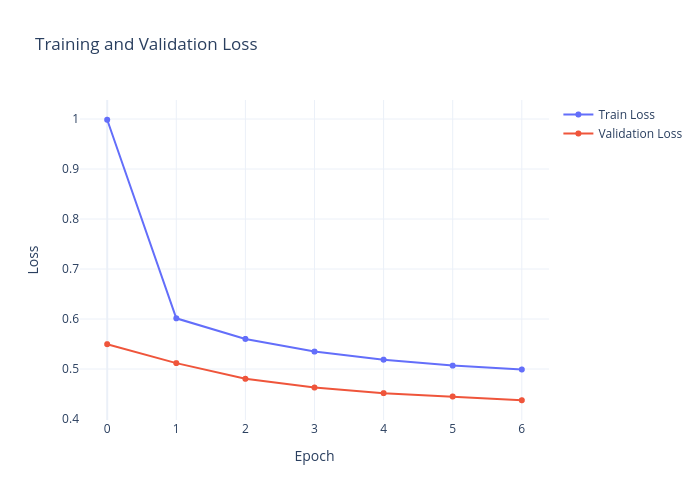

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history['loss'], mode='lines+markers', name='Train Loss'))
fig.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines+markers', name='Validation Loss'))
fig.update_layout(title='Training and Validation Loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss',
                  template='plotly_white')
fig.show()

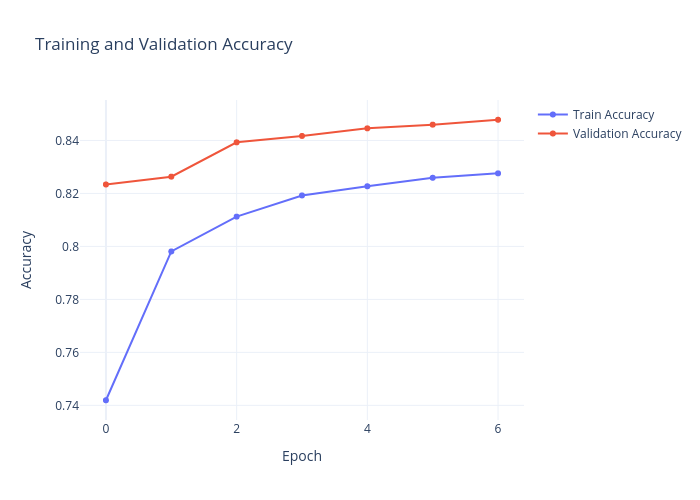

In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history['accuracy'], mode='lines+markers', name='Train Accuracy'))
fig.add_trace(go.Scatter(y=history.history['val_accuracy'], mode='lines+markers', name='Validation Accuracy'))
fig.update_layout(title='Training and Validation Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy',
                  template='plotly_white')
fig.show()


119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


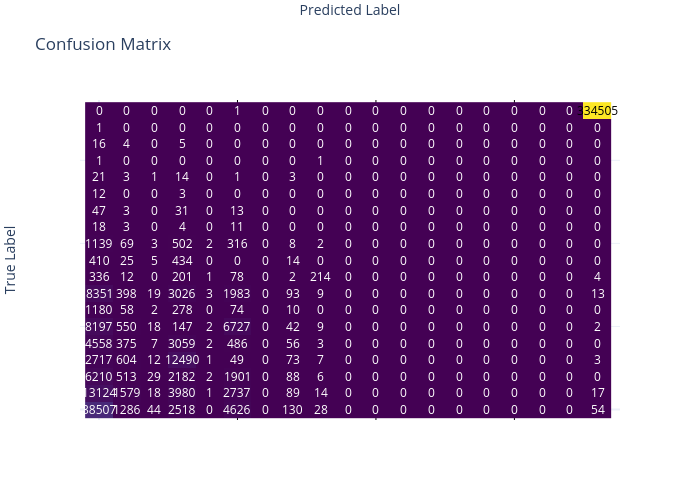

In [28]:
# Assuming model.predict() and appropriate post-processing to get classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_true_classes = np.argmax(y_test, axis=-1)

cm = confusion_matrix(y_true_classes.flatten(), y_pred_classes.flatten())

fig = ff.create_annotated_heatmap(z=cm, colorscale='Viridis')
fig.update_layout(title='Confusion Matrix',
                  xaxis_title='Predicted Label',
                  yaxis_title='True Label',
                  template='plotly_white')
fig.show()


<div id="conclusion"></div> 

# Conclusion
* Its clear that the LSTM does a much better job at predicting a pitch than the decision tree model. The top model from the decision tree group had a prediction accuracy of 34.4% while an LSTM easily achieved 84% accuracy. To be forward I am slightly concerned with the high preformance and for next steps would want to more carefully comb over the feature engineering to ensure that no lookahead bug was introduced. I am fairly confident that this is not an issue as the features provided are simple. The LSTM has the inherent ability to consider context which is so important for this task, its possible that this preformance is geniune. Its also possible that the padding is being counted as a correct prediction, However, I am fairly sure this is not the case do to the confusion matrix highlighting padded predictions.
  
* The fact that validation data does better than the training data can sometimes be indicative of a problem. Some explainations for this are below.
    * Batch effects of training could hurt preformance during training, this effect isn't around for testing. 
    * Dropout decreases accuracy then at run time the model gets a boost from using all parameters.
    * A real world explaination of this would be that the validation is the end of the data frame, perhaps pitcher pitch more predictably during the post season. 
 
* Finally, The decision tree section makes it clear that considering who is pitching increases preformance. Its possible this increase in preformance would be sligtly degraded by the LSTM as it considers the whole plate appearance for prediction, so after the first few pitches the transformer may begin to group a pitcher's tendencies.
  
# Future work

* Besides model validation to ensure LSTM preformance is geniune, it would be a good idea to get the pitcher_id involved in the LSTM. This would ideally take the form of vectorizing each pitcher giving them "personality traits". This would involve a more complex model strutcure. However it was clear from the decision tree  
* On an unrelated note, this pipeline could be used for many other prediction tasks, now that it is built out it could be used to predict what area of the stike zone a ball will cross or perhaps batting outcomes. 
<br>
<br>

[back to top](#outline_swish) 